In [129]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time

# Load the Time-Series data from Mastra
mastra_df = pd.read_csv('mastra.csv')

# reg ex to replace , with . on the whole document
mastra_df = mastra_df.replace({',': '.'}, regex=True)
mastra_df = mastra_df.replace({'LÃ¸rdag': "Loerdag"}, regex=True)
mastra_df = mastra_df.replace({'SÃ¸ndag': "Soendag"}, regex=True)


mastra_df.rename(columns={'MÃ¥ned': 'Maened'}, inplace=True)
mastra_df.rename(columns={'Ãrstal': 'Aarstal'}, inplace=True)
mastra_df.rename(columns={'ï»¿Vej-Id': 'Vej-Id'}, inplace=True)

#mastra_df.drop(columns=['Unnamed: 1', 'Unnamed: 2'], inplace=True)

# Correct column names if necessary
columns_to_convert = [
    'Trafiktype',
    'Dagtype',
    'Vej-Id',
    'Retning',
    'Trafiktype'
]

# Convert the specified columns to float64
mastra_df = mastra_df.astype({col: 'string' for col in columns_to_convert})
mastra_df = mastra_df.replace({'<NA>': ""}, regex=True)

# Identify the columns that are not part of the time intervals
id_vars_columns = [
    'Vej-Id', 'Kilometer', 'Retning', 'Spor', 'Dato', 'Aarstal', 
    'Maened', 'Dag', 'Dagtype', 'Trafiktype', 'Xkoordinat', 'Ykoordinat'
]

# The time interval columns
time_columns = [
    "00:00-00:15","00:15-00:30","00:30-00:45","00:45-01:00","01:00-01:15","01:15-01:30","01:30-01:45","01:45-02:00","02:00-02:15","02:15-02:30","02:30-02:45","02:45-03:00","03:00-03:15","03:15-03:30","03:30-03:45","03:45-04:00","04:00-04:15","04:15-04:30","04:30-04:45","04:45-05:00","05:00-05:15","05:15-05:30","05:30-05:45","05:45-06:00","06:00-06:15","06:15-06:30","06:30-06:45","06:45-07:00","07:00-07:15","07:15-07:30","07:30-07:45","07:45-08:00","08:00-08:15","08:15-08:30","08:30-08:45","08:45-09:00","09:00-09:15","09:15-09:30","09:30-09:45","09:45-10:00","10:00-10:15","10:15-10:30","10:30-10:45","10:45-11:00","11:00-11:15","11:15-11:30","11:30-11:45","11:45-12:00","12:00-12:15","12:15-12:30","12:30-12:45","12:45-13:00","13:00-13:15","13:15-13:30","13:30-13:45","13:45-14:00","14:00-14:15","14:15-14:30","14:30-14:45","14:45-15:00","15:00-15:15","15:15-15:30","15:30-15:45","15:45-16:00","16:00-16:15","16:15-16:30","16:30-16:45","16:45-17:00","17:00-17:15","17:15-17:30","17:30-17:45","17:45-18:00","18:00-18:15","18:15-18:30","18:30-18:45","18:45-19:00","19:00-19:15","19:15-19:30","19:30-19:45","19:45-20:00","20:00-20:15","20:15-20:30","20:30-20:45","20:45-21:00","21:00-21:15","21:15-21:30","21:30-21:45","21:45-22:00","22:00-22:15","22:15-22:30","22:30-22:45","22:45-23:00","23:00-23:15","23:15-23:30","23:30-23:45","23:45-24:00"
]

# Melt the DataFrame to reshape it from wide format to long format
mastra_df = pd.melt(
    mastra_df,
    id_vars=id_vars_columns,  # Columns that uniquely identify each row
    value_vars=time_columns,  # Time interval columns
    var_name='time_interval',  # Name of the new column for the time intervals
    value_name='traffic_flow'  # Name for the traffic flow data
)

# Extract the start time from 'time_interval'
mastra_df['time_start'] = mastra_df['time_interval'].str[:5]  # Extracts the "00:00" part for sorting
mastra_df['datetime'] = pd.to_datetime(mastra_df['Dato'] + " " + mastra_df['time_start'], dayfirst=True)

mastra_df = mastra_df.sort_values(by=['Vej-Id', 'Dato', 'time_start'])

#mastra_df['datetime'] = mastra_df['datetime'].apply(lambda x: int(time.mktime(x.timetuple())))

# Create a dictionary to store the DataFrames with unique key identifiers
grouped_dataframes = {}

# Group by the specified columns
for key, group in mastra_df.groupby(["Vej-Id", "Xkoordinat", "Ykoordinat"]):
    # Convert the 'datetime' column to Unix timestamps in seconds
    group['datetime'] = group['datetime'].apply(lambda x: int(time.mktime(x.timetuple())))

    # Use the unique key for naming or accessing each DataFrame
    sorted_group = group.sort_values(by=['Vej-Id', 'Dato', 'time_start'])
    grouped_dataframes[key] = sorted_group.reset_index(drop=True, inplace=False).set_index('datetime', inplace=False)

In [130]:
grouped_dataframes = pd.read_pickle('grouped_dataframes.pkl')

KeyboardInterrupt: 

In [ ]:
names = list(grouped_dataframes.keys())
print(len(grouped_dataframes))

485


In [ ]:
# Get the shape of the first dataframe
first_shape = list(grouped_dataframes.values())[0].shape

# Check if all dataframes have the same shape
all_same_size = all(df.shape == first_shape for df in grouped_dataframes.values())

print("All dataframes are the same size:", all_same_size)

All dataframes are the same size: False


In [ ]:
# Count the number of dataframes that do not have the same shape as the first dataframe
not_same_size_count = sum(1 for df in grouped_dataframes.values() if df.shape != first_shape)

print("Number of dataframes that are not the same size:", not_same_size_count)

Number of dataframes that are not the same size: 478


In [ ]:
grouped_dataframes[names[0]].head()

,Vej-Id,Kilometer,Retning,Spor,Dato,Aarstal,Maened,Dag,Dagtype,Trafiktype,Xkoordinat,Ykoordinat,time_interval,traffic_flow,time_start
datetime,,,,,,,,,,,,,,,
1675206000,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:00-00:15,10.0,00:00
1675206900,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:15-00:30,10.0,00:15
1675207800,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:30-00:45,7.0,00:30
1675208700,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:45-01:00,3.0,00:45
1675209600,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,01:00-01:15,3.0,01:00


In [ ]:
columns_to_keep = ['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][columns_to_keep]


# Verify Verify the the columns columns of 
grouped_dataframes[names[73]]


,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672527600,0 70-0 290/ 540 +,01.01.2023,559046.0,6321816.0,21.0,00:00
1672528500,0 70-0 290/ 540 +,01.01.2023,559046.0,6321816.0,24.0,00:15
1672529400,0 70-0 290/ 540 +,01.01.2023,559046.0,6321816.0,61.0,00:30
1672530300,0 70-0 290/ 540 +,01.01.2023,559046.0,6321816.0,95.0,00:45
1672531200,0 70-0 290/ 540 +,01.01.2023,559046.0,6321816.0,114.0,01:00
...,...,...,...,...,...,...
1704059100,0 70-0 290/ 540 +,31.12.2023,559046.0,6321816.0,40.0,22:45
1704060000,0 70-0 290/ 540 +,31.12.2023,559046.0,6321816.0,NaN,23:00
1704060900,0 70-0 290/ 540 +,31.12.2023,559046.0,6321816.0,NaN,23:15


In [ ]:
for key, df in grouped_dataframes.items():
    if df['Vej-Id'].str.contains('0 70-0 290/').any():
        print(f"DataFrame for key: {key}")


DataFrame for key: ('0 70-0 290/ 30 -', 559025.0, 6321308.0)
DataFrame for key: ('0 70-0 290/ 30 -1', 559025.0, 6321308.0)
DataFrame for key: ('0 70-0 290/ 30 -2', 559025.0, 6321308.0)
DataFrame for key: ('0 70-0 290/ 540 +', 559046.0, 6321816.0)
DataFrame for key: ('0 70-0 290/ 540 +1', 559046.0, 6321816.0)
DataFrame for key: ('0 70-0 290/ 540 +2', 559046.0, 6321816.0)
DataFrame for key: ('0 70-0 290/ 900 -', 559030.0, 6322175.0)
DataFrame for key: ('0 70-0 290/ 900 -1', 559030.0, 6322175.0)
DataFrame for key: ('0 70-0 290/ 900 -2', 559030.0, 6322175.0)
DataFrame for key: ('0 70-0 290/ 951 +', 559026.0, 6322227.0)
DataFrame for key: ('0 70-0 290/ 951 +1', 559026.0, 6322227.0)
DataFrame for key: ('0 70-0 290/ 951 +2', 559026.0, 6322227.0)
DataFrame for key: ('0 70-0 290/ 951 T', 559026.0, 6322227.0)


In [ ]:
test=grouped_dataframes[('0 70-0 290/ 951 T', 559026.0, 6322227.0)]
test.head(2)

,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672527600,0 70-0 290/ 951 T,01.01.2023,559026.0,6322227.0,36.0,00:00
1672528500,0 70-0 290/ 951 T,01.01.2023,559026.0,6322227.0,59.0,00:15


In [ ]:
test2 = grouped_dataframes[('0 70-0 290/ 951 +2', 559026.0, 6322227.0)]
test2.head(2)

,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672527600,0 70-0 290/ 951 +2,01.01.2023,559026.0,6322227.0,20.0,00:00
1672528500,0 70-0 290/ 951 +2,01.01.2023,559026.0,6322227.0,23.0,00:15


In [ ]:
test3 = grouped_dataframes[('0 70-0 290/ 951 +1', 559026.0, 6322227.0)]
test3.head(2)

,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672527600,0 70-0 290/ 951 +1,01.01.2023,559026.0,6322227.0,1.0,00:00
1672528500,0 70-0 290/ 951 +1,01.01.2023,559026.0,6322227.0,1.0,00:15


In [ ]:
test4 = grouped_dataframes[('0 70-0 290/ 951 +', 559026.0, 6322227.0)]
test4.head(2)

,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672527600,0 70-0 290/ 951 +,01.01.2023,559026.0,6322227.0,21.0,00:00
1672528500,0 70-0 290/ 951 +,01.01.2023,559026.0,6322227.0,24.0,00:15


In [ ]:
names = list(grouped_dataframes.keys())
filtered_dataframes = {}
for name in names:
    single_name = name[0]
    if single_name[-1] in ["T"]:
        filtered_dataframes[name] = grouped_dataframes[name]

len(filtered_dataframes)

137

In [ ]:
grouped_dataframes = filtered_dataframes

In [ ]:
for key, df in grouped_dataframes.items():
    df['traffic_flow'] = df['traffic_flow'].apply(lambda x: x * 10**3 if not pd.isna(x) and x != int(x) else x)

In [ ]:
for key, df in grouped_dataframes.items():
    if (df['traffic_flow'].astype(float) > 999).any():
        print(f"Key for dataframe with 'traffic_flow' over 1000: {key}")
        break #Remove this line if you want to print all such keys

Key for dataframe with 'traffic_flow' over 1000: ('0 70-0 277/ 100 T', 552269.0, 6311346.0)


In [ ]:
lowest_datetime = min(df.index.min() for df in grouped_dataframes.values())
print("Lowest 'datetime' index for all dataframes:", lowest_datetime)

Lowest 'datetime' index for all dataframes: 1672527600


In [ ]:
# Convert 'Dato' column to datetime if not already
for key in grouped_dataframes.keys():
    grouped_dataframes[key]['Dato'] = pd.to_datetime(grouped_dataframes[key]['Dato'], format='%d.%m.%Y')

# Find the earliest and latest date
earliest_date = min(df['Dato'].min() for df in grouped_dataframes.values())
latest_date = max(df['Dato'].max() for df in grouped_dataframes.values())

print("Earliest date:", earliest_date)
print("Latest date:", latest_date)

Earliest date: 2023-01-01 00:00:00
Latest date: 2024-08-31 00:00:00


In [ ]:
import pandas as pd
import numpy as np
import time

# Define the date range
date_range = pd.date_range(start='2023-01-01', end='2024-08-31', freq='D')

# Define the time range with 15-minute intervals
time_range = pd.date_range(start='00:00', end='23:45', freq='15T').time

# Create a MultiIndex with all combinations of dates and times
multi_index = pd.MultiIndex.from_product([date_range, time_range], names=['Dato', 'time_start'])

# Create the DataFrame
empty_df = pd.DataFrame(index=multi_index, columns=['Vej-Id', 'Xkoordinat', 'Ykoordinat', 'traffic_flow'])

# Reset the index to have 'datetime' as a column
empty_df = empty_df.reset_index()

# Format 'Dato' as mm.dd.yyyy
empty_df['Dato'] = empty_df['Dato'].dt.strftime('%d.%m.%Y')

# Combine 'Dato' and 'time_start' into a single datetime column (ensure correct formatting)
empty_df['datetime'] = pd.to_datetime(empty_df['Dato'] + ' ' + empty_df['time_start'].astype(str), format='%d.%m.%Y %H:%M:%S')

# Convert datetime to UNIX timestamp
empty_df['datetime'] = empty_df['datetime'].apply(lambda dt: int(time.mktime(dt.timetuple())))

# Set 'datetime' as the index
empty_df = empty_df.set_index('datetime')

# Ensure 'time_start' contains only hour and minutes as strings
empty_df['time_start'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%H:%M'))

# Fill other columns with placeholder data
empty_df['Vej-Id'] = np.nan  # Placeholder for Vej-Id
empty_df['Dato'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%d.%m.%Y'))  # Re-format Dato column

# Set NaN for other columns
empty_df['Xkoordinat'] = np.nan          # Set NaN for Xkoordinat
empty_df['Ykoordinat'] = np.nan          # Set NaN for Ykoordinat
empty_df['traffic_flow'] = np.nan        # Set NaN for traffic_flow

# Reorder columns
empty_df = empty_df[['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']]

# Remove the first 4 rows and adjust index
empty_df = empty_df.iloc[4:]
empty_df.index = empty_df.index - 3600  # Subtract 3600 seconds (1 hour) from each index value

# Display the first few rows of the modified DataFrame
empty_df.shape


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_6876/1012148002.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:45', freq='15T').time


(58460, 6)

In [ ]:
# Define the additional time range for 31.08.2024
additional_time_range = pd.date_range(start='2024-08-31 22:00', end='2024-08-31 23:45', freq='15T')

# Create a DataFrame for the new rows
additional_df = pd.DataFrame({
    'datetime': additional_time_range.map(lambda dt: int(time.mktime(dt.timetuple()))),  # Convert to UNIX timestamp
    'Vej-Id': np.nan,
    'Dato': additional_time_range.strftime('%d.%m.%Y'),
    'Xkoordinat': np.nan,
    'Ykoordinat': np.nan,
    'traffic_flow': np.nan,
    'time_start': additional_time_range.strftime('%H:%M'),
})

# Set 'datetime' as the index
additional_df = additional_df.set_index('datetime')

# Append the new rows to the original DataFrame
empty_df = pd.concat([empty_df, additional_df])

# Display the last few rows to verify
empty_df.shape


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_6876/2795952495.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  additional_time_range = pd.date_range(start='2024-08-31 22:00', end='2024-08-31 23:45', freq='15T')


(58468, 6)

In [ ]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][~grouped_dataframes[key].index.duplicated(keep='first')]

In [ ]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key] = empty_df.combine_first(grouped_dataframes[key])

# Verify the result for one of the dataframes
#grouped_dataframes[names[73]].head()

In [ ]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][~grouped_dataframes[key].index.duplicated(keep='first')]

In [ ]:
#grouped_dataframes[names[73]].head()

In [ ]:
print(len(grouped_dataframes))

137


In [ ]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key]['Vej-Id'] = grouped_dataframes[key]['Vej-Id'].ffill().bfill()
    grouped_dataframes[key]['Xkoordinat'] = grouped_dataframes[key]['Xkoordinat'].ffill().bfill()
    grouped_dataframes[key]['Ykoordinat'] = grouped_dataframes[key]['Ykoordinat'].ffill().bfill()


# Verify the result for one of the dataframes
#grouped_dataframes[names[0]].head()

In [ ]:
#for key in grouped_dataframes.keys():
#    grouped_dataframes[key]['Vej-Id'] = grouped_dataframes[key]['Vej-Id'].str[:-1]


In [ ]:
print(len(grouped_dataframes))

137


In [ ]:
# Create a new dictionary to store the aggregated dataframes
aggregated_dataframes = {}

# Iterate over the grouped dataframes
for key, df in grouped_dataframes.items():
    # Create a unique key based on Xkoordinat and Ykoordinat
    coord_key = (df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0])
    
    if coord_key not in aggregated_dataframes:
        # Initialize the dataframe in the aggregated dictionary
        aggregated_dataframes[coord_key] = df.copy()
    else:
        # Aggregate traffic_flow by summing up the values, ignoring NaNs
        aggregated_dataframes[coord_key]['traffic_flow'] += df['traffic_flow'].fillna(0)
        
        # Keep the shortest Vej-Id
        aggregated_dataframes[coord_key]['Vej-Id'] = aggregated_dataframes[coord_key]['Vej-Id'].combine(
            df['Vej-Id'], lambda x, y: x if len(x) < len(y) else y
        )


# Verify the result for one of the aggregated dataframes
aggregated_dataframes[list(aggregated_dataframes.keys())[0]].head()

,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672527600,0 450-0 7/ 300 T,01.01.2023,552601.0,6329842.0,NaN,00:00
1672528500,0 450-0 7/ 300 T,01.01.2023,552601.0,6329842.0,NaN,00:15
1672529400,0 450-0 7/ 300 T,01.01.2023,552601.0,6329842.0,NaN,00:30
1672530300,0 450-0 7/ 300 T,01.01.2023,552601.0,6329842.0,NaN,00:45
1672531200,0 450-0 7/ 300 T,01.01.2023,552601.0,6329842.0,NaN,01:00


In [ ]:
print(len(aggregated_dataframes))

136


In [ ]:
nan_percentage = {}
aggregated_dataframes = aggregated_dataframes

for key, df in aggregated_dataframes.items():
    nan_count = df['traffic_flow'].isna().sum()
    total_count = len(df)
    nan_percentage[key] = (nan_count / total_count) * 100

thresholds = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
counts = {threshold: sum(percentage > threshold for percentage in nan_percentage.values()) for threshold in thresholds}

for threshold, count in counts.items():
    print(f"Number of values above {threshold}%: {count}")

Number of values above 5%: 89
Number of values above 10%: 59
Number of values above 15%: 47
Number of values above 20%: 36
Number of values above 25%: 34
Number of values above 30%: 31
Number of values above 35%: 29
Number of values above 40%: 29
Number of values above 45%: 13
Number of values above 50%: 11
Number of values above 55%: 6
Number of values above 60%: 6
Number of values above 65%: 0


In [ ]:
# Get the index of the first dataframe
common_index = set(aggregated_dataframes[list(aggregated_dataframes.keys())[0]].index)

# Intersect with the index of all other dataframes
for df in aggregated_dataframes.values():
    common_index &= set(df.index)

# Check if there are common index values
if common_index:
    print("Common index values across all dataframes:", common_index)
else:
    print("No common index values found across all dataframes.")

print(len(common_index))

Common index values across all dataframes: {1680998400, 1710489600, 1696464900, 1711931400, 1682440200, 1697906700, 1683882000, 1713373200, 1699348500, 1685323800, 1714815000, 1700790300, 1686765600, 1716256800, 1672740900, 1702232100, 1688207400, 1717698600, 1674182700, 1703673900, 1689649200, 1719140400, 1675624500, 1705115700, 1691091000, 1720582200, 1677066300, 1706557500, 1692532800, 1722024000, 1678508100, 1707999300, 1693974600, 1723465800, 1679949900, 1709441100, 1695416400, 1724907600, 1681391700, 1710882900, 1696858200, 1682833500, 1712324700, 1698300000, 1684275300, 1713766500, 1699741800, 1685717100, 1715208300, 1701183600, 1687158900, 1716650100, 1673134200, 1702625400, 1688600700, 1718091900, 1674576000, 1704067200, 1690042500, 1719533700, 1676017800, 1705509000, 1691484300, 1720975500, 1677459600, 1706950800, 1692926100, 1722417300, 1678901400, 1708392600, 1694367900, 1723859100, 1680343200, 1709834400, 1695809700, 1681785000, 1711276200, 1697251500, 1683226800, 17127180

In [ ]:
#aggregated_dataframes = {key: df for key, df in aggregated_dataframes.items() if nan_percentage[key] <= 45}


In [ ]:

def find_longest_non_nan_period(df, threshold=None, tolerance=0):
    """
    Finds the longest continuous period in a DataFrame where there are no NaN values in most columns,
    with tolerance for short gaps.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    threshold (float): The minimum proportion of non-NaN values in each row (e.g., 0.8 for 80% of columns).
                       If None, defaults to 50% (more than half of columns).
    tolerance (int): The maximum number of consecutive rows with NaN values that are tolerated as part of the period.

    Returns:
    pd.DataFrame: Cropped DataFrame to the longest continuous period with minimal NaN values.
    """
    # Set default threshold to more than half of the columns if not specified
    if threshold is None:
        threshold = 0.5

    # Calculate the required number of non-NaN values per row
    required_non_nan = int(len(df.columns) * threshold)

    # Create a boolean mask where each row has True if it meets the non-NaN requirement
    valid_rows = df.notna().sum(axis=1) >= required_non_nan

    # Variables to track the longest valid period
    max_start = max_end = temp_start = temp_length = max_length = 0
    gap_count = 0  # Count of consecutive invalid rows within tolerance

    for i, valid in enumerate(valid_rows):
        if valid:
            if temp_length == 0:
                temp_start = i  # Start a new period
            temp_length += 1
            gap_count = 0  # Reset gap count as we are in a valid row
        else:
            if gap_count >= tolerance:
                if temp_length > max_length:
                    max_start, max_end = temp_start, temp_start + temp_length
                    max_length = temp_length
                temp_length = 0
                gap_count = 0


    # Final check in case the longest period ends at the last row
    if temp_length > max_length:
        max_start, max_end = temp_start, temp_start + temp_length

    # Crop the DataFrame to the longest continuous non-NaN period
    return df.iloc[max_start:max_end]
    # Iterate through every dataframe in aggregated_dataframes and find the longest non-NaN period

In [ ]:
one_week_dfs1 = {}
for key in aggregated_dataframes.keys():
        one_week_dfs1[key] = find_longest_non_nan_period(aggregated_dataframes[key], threshold=1, tolerance=0)
        
one_week_dfs1[list(one_week_dfs1.keys())[0]]

,Vej-Id,Dato,Xkoordinat,Ykoordinat,traffic_flow,time_start
datetime,,,,,,
1672959600,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,22.0,00:00
1672960500,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,14.0,00:15
1672961400,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,8.0,00:30
1672962300,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,11.0,00:45
1672963200,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,4.0,01:00
...,...,...,...,...,...,...
1673037900,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,72.0,21:45
1673038800,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,99.0,22:00
1673039700,0 450-0 7/ 300 T,06.01.2023,552601.0,6329842.0,77.0,22:15


In [ ]:
one_week_dfs = {}
for key in aggregated_dataframes.keys():
        one_week_dfs[key] = find_longest_non_nan_period(aggregated_dataframes[key], threshold=1, tolerance=2)



In [ ]:
nan_percentage = {}

for key, df in one_week_dfs.items():
    nan_count = df['traffic_flow'].isna().sum()
    total_count = len(df)
    nan_percentage[key] = (nan_count / total_count) * 100

thresholds = [3, 3.5, 3.9, 4, 5, 10, 15, 20, 25]
counts = {threshold: sum(percentage > threshold for percentage in nan_percentage.values()) for threshold in thresholds}

for threshold, count in counts.items():
    print(f"Number of values above {threshold}%: {count}")

Number of values above 3%: 136
Number of values above 3.5%: 94
Number of values above 3.9%: 78
Number of values above 4%: 77
Number of values above 5%: 60
Number of values above 10%: 22
Number of values above 15%: 13
Number of values above 20%: 5
Number of values above 25%: 1


In [ ]:
# Calculate the percentage of NaN values in 'traffic_flow' for each dataframe
nan_percentage_one_week = {key: (df['traffic_flow'].isna().sum() / len(df)) * 100 for key, df in one_week_dfs.items()}

# Filter out dataframes with NaN percentage above 5%
one_week_dfs = {key: df for key, df in one_week_dfs.items() if nan_percentage_one_week[key] <= 50}

# Verify the result
print(f"Number of dataframes after filtering: {len(one_week_dfs)}")

Number of dataframes after filtering: 136


In [ ]:
highest_starting_index = max(df.index[0] for df in one_week_dfs.values())
lowest_ending_index = min(df.index[-1] for df in one_week_dfs.values())

print("Highest starting index value:", highest_starting_index)
print("Lowest ending index value:", lowest_ending_index)
print(((lowest_ending_index - highest_starting_index)/3600)/24)

Highest starting index value: 1704063600
Lowest ending index value: 1698291000
-66.8125


In [ ]:
def remove_extreme_dataframes(one_week_dfs, n, m):
    # Sort dataframes by their starting index value
    sorted_by_start = sorted(one_week_dfs.items(), key=lambda item: item[1].index[0])
    
    # Sort dataframes by their ending index value
    sorted_by_end = sorted(one_week_dfs.items(), key=lambda item: item[1].index[-1])
    
    # Remove n dataframes with the highest starting index value
    to_remove_start = sorted_by_start[-n:]
    
    # Remove m dataframes with the lowest ending index value
    to_remove_end = sorted_by_end[:m]
    
    # Create a set of keys to remove
    keys_to_remove = set(key for key, _ in to_remove_start + to_remove_end)
    
    # Remove the dataframes from one_week_dfs
    one_week_dfs = {key: df for key, df in one_week_dfs.items() if key not in keys_to_remove}
    
    return one_week_dfs

# Example usage
#n = 1  # Number of dataframes to remove with the highest starting index value
#m = 1  # Number of dataframes to remove with the lowest ending index value
#one_week_dfs = remove_extreme_dataframes(one_week_dfs, n, m)

# Verify the result
#print(f"Number of dataframes after removal: {len(one_week_dfs)}")

In [ ]:
for n in range(0, 11):
    for m in range(0, 11):
        temp_one_week_dfs = remove_extreme_dataframes(one_week_dfs, n, m)
        
        if temp_one_week_dfs:  # Check if temp_one_week_dfs is not empty
            highest_starting_index = max(df.index[0] for df in temp_one_week_dfs.values())
            lowest_ending_index = min(df.index[-1] for df in temp_one_week_dfs.values())
            duration_days = ((lowest_ending_index - highest_starting_index) / 3600) / 24

            if duration_days >= 0:
                print(f"n = {n}, m = {m}")
                #print("Number of dataframes after removal:", len(temp_one_week_dfs))
                #print("Highest starting index value:", highest_starting_index)
                #print("Lowest ending index value:", lowest_ending_index)
                print("Duration in days:", duration_days)
                print()

n = 6, m = 0
Duration in days: 179.22916666666666

n = 6, m = 1
Duration in days: 184.97916666666666

n = 6, m = 2
Duration in days: 185.1875

n = 6, m = 3
Duration in days: 197.36458333333334

n = 6, m = 4
Duration in days: 212.27083333333334

n = 6, m = 5
Duration in days: 220.10416666666666

n = 6, m = 6
Duration in days: 221.03125

n = 6, m = 7
Duration in days: 221.03125

n = 6, m = 8
Duration in days: 228.8125

n = 6, m = 9
Duration in days: 228.8125

n = 6, m = 10
Duration in days: 228.8125

n = 7, m = 0
Duration in days: 179.22916666666666

n = 7, m = 1
Duration in days: 184.97916666666666

n = 7, m = 2
Duration in days: 185.1875

n = 7, m = 3
Duration in days: 197.36458333333334

n = 7, m = 4
Duration in days: 212.27083333333334

n = 7, m = 5
Duration in days: 220.10416666666666

n = 7, m = 6
Duration in days: 221.03125

n = 7, m = 7
Duration in days: 221.03125

n = 7, m = 8
Duration in days: 228.8125

n = 7, m = 9
Duration in days: 228.8125

n = 7, m = 10
Duration in days: 22

In [ ]:
n = 6  # Number of dataframes to remove with the highest starting index value
m = 0  # Number of dataframes to remove with the lowest ending index value
one_week_dfs = remove_extreme_dataframes(one_week_dfs, n, m)

In [ ]:
highest_starting_index = max(df.index[0] for df in one_week_dfs.values())
lowest_ending_index = min(df.index[-1] for df in one_week_dfs.values())

print("Highest starting index value:", highest_starting_index)
print("Lowest ending index value:", lowest_ending_index)
print(((lowest_ending_index - highest_starting_index)/3600)/24)
print(len(one_week_dfs))

Highest starting index value: 1682805600
Lowest ending index value: 1698291000
179.22916666666666
130


In [ ]:
start_index = 1682805600
end_index = 1698743700

for key in one_week_dfs.keys():
    one_week_dfs[key] = one_week_dfs[key].loc[start_index:end_index]

In [ ]:
import random

# Select 10 random keys from one_week_dfs
random_keys = random.sample(list(one_week_dfs.keys()), 10)

# Print the shape of the dataframes corresponding to the random keys
for key in random_keys:
    print(f"Shape of dataframe {key}: {one_week_dfs[key].shape}")

Shape of dataframe (558845.0, 6327312.0): (17709, 6)
Shape of dataframe (552730.0, 6312348.0): (17709, 6)
Shape of dataframe (557255.0, 6324952.0): (17709, 6)
Shape of dataframe (557994.0, 6326153.0): (17709, 6)
Shape of dataframe (557929.0, 6324261.0): (17709, 6)
Shape of dataframe (562278.0, 6328919.0): (17709, 6)
Shape of dataframe (558981.0, 6322888.0): (17709, 6)
Shape of dataframe (561226.0, 6328459.0): (17709, 6)
Shape of dataframe (558465.0, 6323359.0): (17709, 6)
Shape of dataframe (553320.0, 6318000.0): (17709, 6)


In [ ]:
def fill_nan_with_mean(df):
    """
    Fill NaN values in 'traffic_flow' with the absolute mean of the two nearest values.
    """
    for i in range(len(df)):
        if pd.isna(df.iloc[i]['traffic_flow']):
            prev_value = df.iloc[i-1]['traffic_flow'] if i > 0 else np.nan
            next_value = df.iloc[i+1]['traffic_flow'] if i < len(df) - 1 else np.nan
            
            if not pd.isna(prev_value) and not pd.isna(next_value):
                df.at[df.index[i], 'traffic_flow'] = abs(prev_value + next_value) / 2
            elif not pd.isna(prev_value):
                df.at[df.index[i], 'traffic_flow'] = prev_value
            elif not pd.isna(next_value):
                df.at[df.index[i], 'traffic_flow'] = next_value

    return df

# Apply the function to each dataframe in one_week_dfs
for key in one_week_dfs.keys():
    one_week_dfs[key] = fill_nan_with_mean(one_week_dfs[key])

In [ ]:
keys_with_nan = [key for key, df in one_week_dfs.items() if df['traffic_flow'].isna().any()]
print("Keys for dataframes containing NaN values:", keys_with_nan)

Keys for dataframes containing NaN values: [(561226.0, 6328459.0), (562278.0, 6328919.0), (561669.0, 6328654.0)]


In [ ]:
keys_to_drop = [(561226.0, 6328459.0), (562278.0, 6328919.0), (561669.0, 6328654.0)]

for key in keys_to_drop:
    if key in one_week_dfs:
        del one_week_dfs[key]

In [ ]:
for key in one_week_dfs.keys():
    one_week_dfs[key]['traffic_flow'] = one_week_dfs[key]['traffic_flow'].abs()

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_6876/3715079893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_week_dfs[key]['traffic_flow'] = one_week_dfs[key]['traffic_flow'].abs()


In [ ]:
basic_data_df = one_week_dfs

In [ ]:
print(len(basic_data_df))

127


In [ ]:
# Define the date range
start_date = pd.to_datetime('08.05.2023', format='%d.%m.%Y')
end_date = pd.to_datetime('11.05.2023', format='%d.%m.%Y')

# Filter the dataframes
for key in basic_data_df.keys():
    basic_data_df[key]['Dato'] = pd.to_datetime(basic_data_df[key]['Dato'], format='%d.%m.%Y')
    basic_data_df[key] = basic_data_df[key][(basic_data_df[key]['Dato'] >= start_date) & (basic_data_df[key]['Dato'] <= end_date)]

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_6876/1809426344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basic_data_df[key]['Dato'] = pd.to_datetime(basic_data_df[key]['Dato'], format='%d.%m.%Y')
/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_6876/1809426344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basic_data_df[key]['Dato'] = pd.to_datetime(basic_data_df[key]['Dato'], format='%d.%m.%Y')
/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_6876/1809426344.p

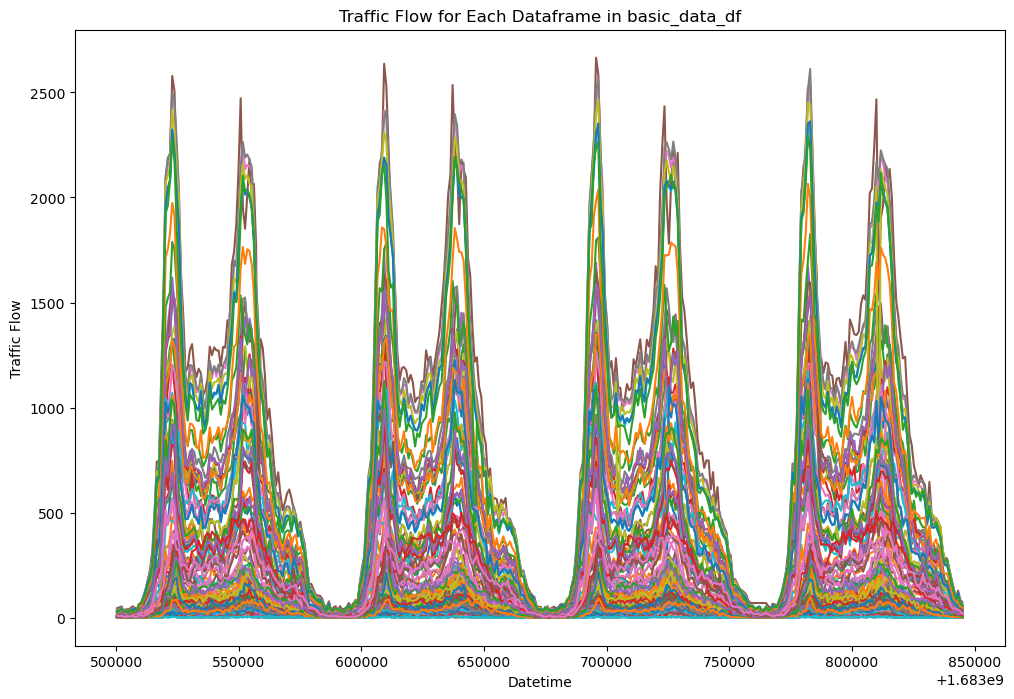

In [ ]:
plt.figure(figsize=(12, 8))

for key, df in basic_data_df.items():
    plt.plot(df.index, df['traffic_flow'], label=str(key))

plt.xlabel('Datetime')
plt.ylabel('Traffic Flow')
plt.title('Traffic Flow for Each Dataframe in basic_data_df')
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

In [ ]:
for key, df in basic_data_df.items():
    df['time_step'] = range(len(df))

In [ ]:
spatial_graph = nx.Graph()

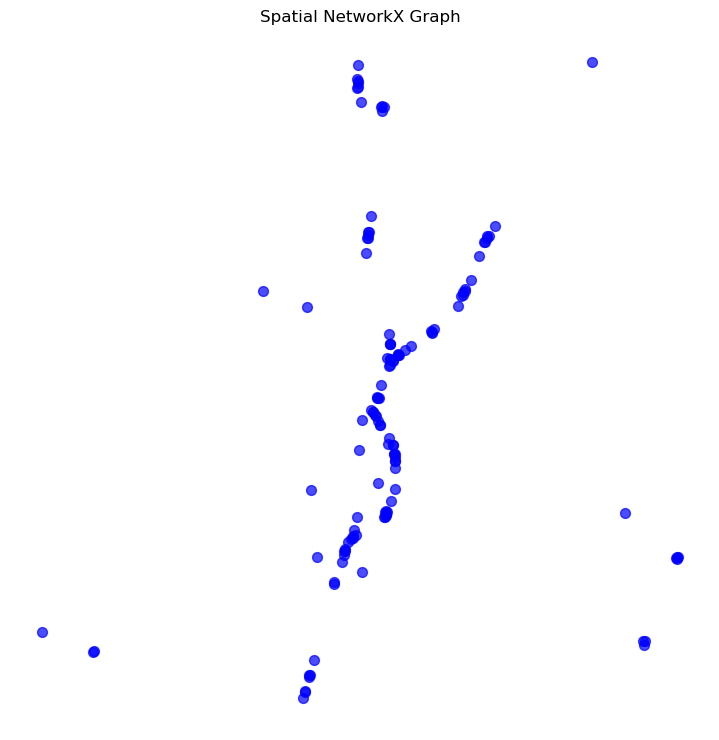

In [ ]:
# Add nodes with desired attributes
for i, (key, df) in enumerate(basic_data_df.items()):  # Use enumerate for unique integer keys
    x = df['Xkoordinat'].iloc[0]
    y = df['Ykoordinat'].iloc[0]
    traffic_flow = np.array(df['traffic_flow'])  # Convert to NumPy array
    time_step = np.array(df['time_step'])  # Convert to NumPy array
    spatial_graph.add_node(i, x=x, y=y, traffic=traffic_flow, time_step=time_step)

G1 = spatial_graph.copy()
G2 = spatial_graph.copy()
G3 = spatial_graph.copy()

# Draw the graph
pos = {node: (data['x'], data['y']) for node, data in spatial_graph.nodes(data=True)}
plt.figure(figsize=(7, 7))
nx.draw(spatial_graph, pos, with_labels=False, node_size=50, node_color="blue", alpha=0.7)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial NetworkX Graph")
plt.show()

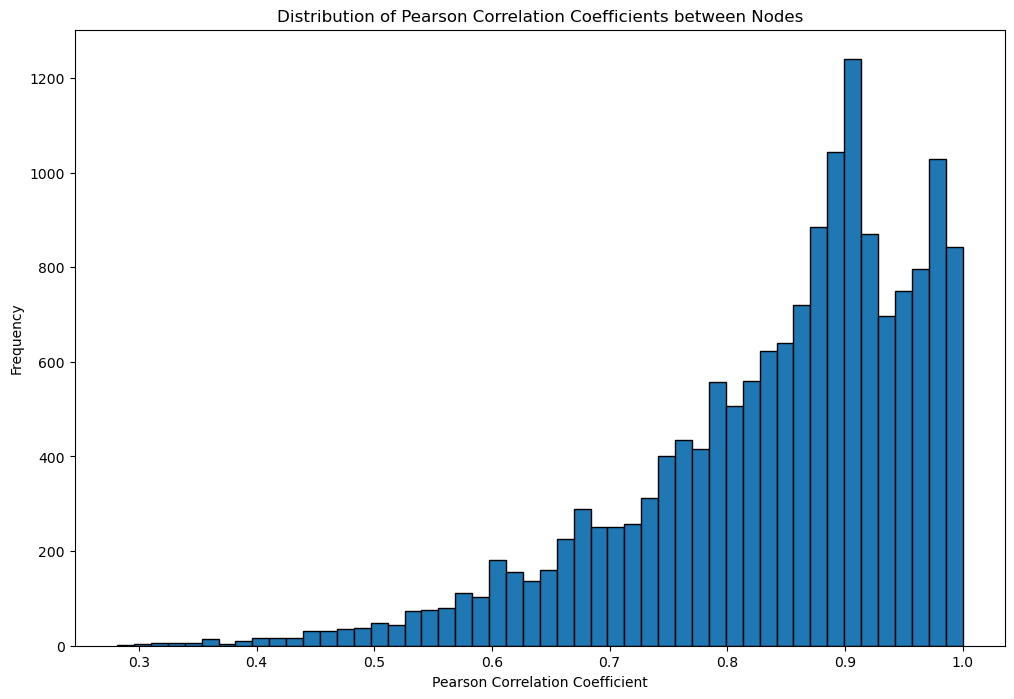

In [ ]:
from scipy.stats import pearsonr

# Initialize a dictionary to store the correlation results
correlation_results = {}

# Iterate over each pair of nodes in G2
for node1, data1 in G1.nodes(data=True):
    for node2, data2 in G1.nodes(data=True):
        if node1 != node2:
            # Calculate the Pearson correlation coefficient between the traffic flows of the two nodes
            correlation, _ = pearsonr(data1['traffic'], data2['traffic'])
            correlation_results[(node1, node2)] = correlation

# Convert the correlation results dictionary to a DataFrame for easier plotting
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['correlation'])

# Reset the index to have node pairs as columns
correlation_df.reset_index(inplace=True)
correlation_df[['node1', 'node2']] = pd.DataFrame(correlation_df['index'].tolist(), index=correlation_df.index)
correlation_df.drop(columns=['index'], inplace=True)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
plt.hist(correlation_df['correlation'], bins=50, edgecolor='k')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Pearson Correlation Coefficients between Nodes')
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Iterate over each pair of nodes in G1
for node1, data1 in G1.nodes(data=True):
    for node2, data2 in G1.nodes(data=True):
        if node1 != node2:
            # Calculate the Pearson correlation coefficient between the traffic flows of the two nodes
            correlation, _ = pearsonr(data1['traffic'], data2['traffic'])
            # Add an edge with the correlation as the weight
            G1.add_edge(node1, node2, weight=correlation)

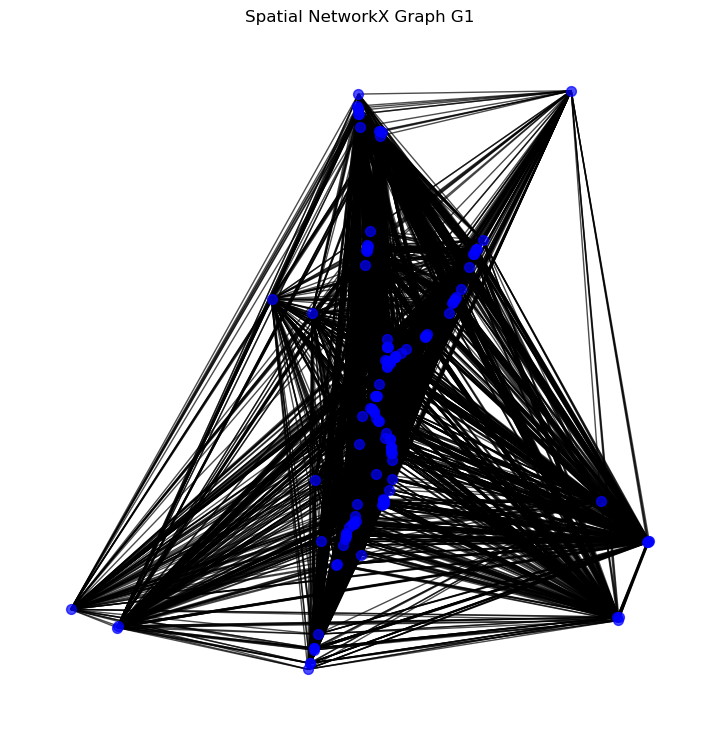

In [ ]:
# Draw the graph G1
pos = {node: (data['x'], data['y']) for node, data in G1.nodes(data=True)}
plt.figure(figsize=(7, 7))
nx.draw(G1, pos, with_labels=False, node_size=50, node_color="blue", alpha=0.7)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial NetworkX Graph G1")
plt.show()



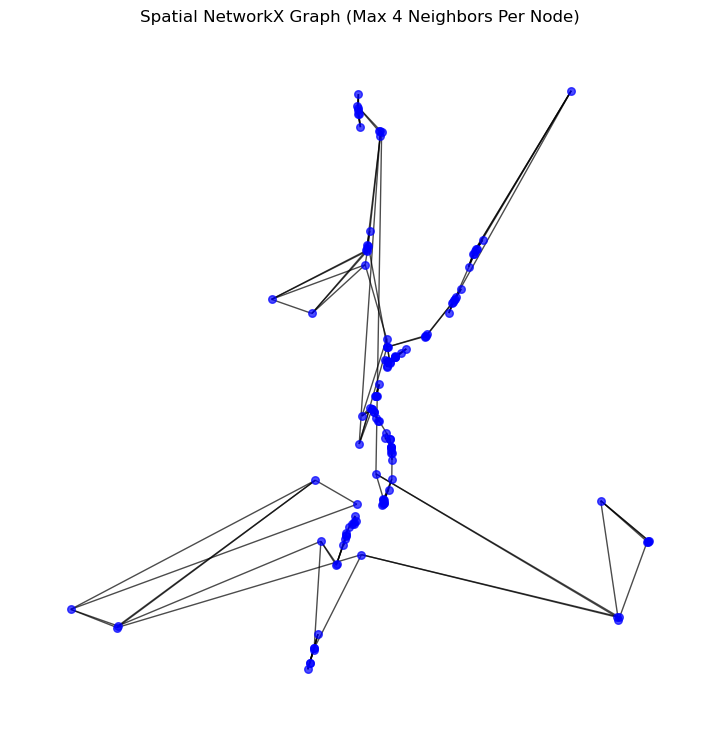

In [ ]:
import networkx as nx
import math

# Copy 'pos' attribute from G3 to G2
for node in G2.nodes:
    if 'x' in G3.nodes[node] and 'y' in G3.nodes[node]:
        G2.nodes[node]['pos'] = (G3.nodes[node]['x'], G3.nodes[node]['y'])

# Define the maximum degree for each node
max_degree = 4

# Iterate over each node in the graph
for node1, data1 in G2.nodes(data=True):
    # Get the current degree of the node
    current_degree = G2.degree[node1]
    
    # If the current degree is less than the maximum degree, find nodes to connect
    if current_degree < max_degree:
        distances = []
        x1, y1 = data1['pos']
        
        # Calculate the distance to all other nodes
        for node2, data2 in G2.nodes(data=True):
            if node1 != node2 and not G2.has_edge(node1, node2):
                x2, y2 = data2['pos']
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                distances.append((distance, node2))
        
        # Sort the distances and add edges to the closest nodes until the max degree is reached
        distances.sort(key=lambda x: x[0])
        for _, closest_node in distances:
            if G2.degree[node1] < max_degree and G2.degree[closest_node] < max_degree:
                G2.add_edge(node1, closest_node)
            if G2.degree[node1] >= max_degree:
                break

# Visualize the graph
pos2 = {node: (data['x'], data['y']) for node, data in G2.nodes(data=True)}
plt.figure(figsize=(7, 7))
nx.draw(G2, pos2, with_labels=False, node_size=30, node_color="blue", alpha=0.7)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial NetworkX Graph (Max 4 Neighbors Per Node)")
plt.show()

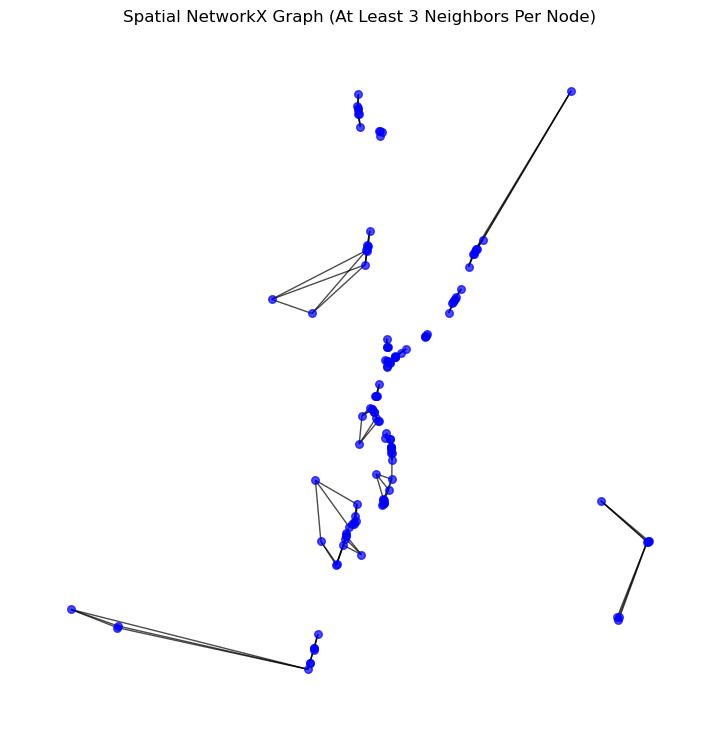

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import math

# Copy 'pos' attribute from G2 to G3
for node in G2.nodes:
    if 'x' in G2.nodes[node] and 'y' in G2.nodes[node]:
        G3.nodes[node]['pos'] = (G2.nodes[node]['x'], G2.nodes[node]['y'])

# Parameters
distance_threshold = 1000
n_edges_sub_1000 = 3  # Desired closest neighbors
n_edges_disctance = 3  # Minimum required neighbors

# First pass: Connect up to `n_edges_sub_1000` closest nodes within the distance threshold
for node1, data1 in G3.nodes(data=True):
    distances = []
    x1, y1 = data1['pos']
    for node2, data2 in G3.nodes(data=True):
        if node1 != node2:
            x2, y2 = data2['pos']
            distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if distance < distance_threshold:
                distances.append((distance, node2))
    
    # Sort and add edges to the closest nodes
    distances.sort(key=lambda x: x[0])
    for _, closest_node in distances[:n_edges_sub_1000]:
        G3.add_edge(node1, closest_node)

# Second pass: Ensure all nodes meet `n_edges_disctance` minimum neighbors
for node in G3.nodes:
    while G3.degree[node] < n_edges_disctance:
        # Find the closest unconnected neighbor
        distances = []
        x1, y1 = G3.nodes[node]['pos']
        for neighbor, data in G3.nodes(data=True):
            if neighbor != node and not G3.has_edge(node, neighbor):
                x2, y2 = data['pos']
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                distances.append((distance, neighbor))
        
        # Sort by distance and add the closest unconnected neighbor
        distances.sort(key=lambda x: x[0])
        if distances:  # If a valid neighbor exists
            _, closest_unconnected_node = distances[0]
            G3.add_edge(node, closest_unconnected_node)
        else:  # Break if no more valid neighbors
            break

# Visualize the graph
pos3 = {node: (data['x'], data['y']) for node, data in G3.nodes(data=True)}
plt.figure(figsize=(7, 7))
nx.draw(G3, pos3, with_labels=False, node_size=30, node_color="blue", alpha=0.7)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial NetworkX Graph (At Least 3 Neighbors Per Node)")
plt.show()


In [ ]:
G1.edges(data=True)

EdgeDataView([(0, 1, {'weight': 0.99378582780808}), (0, 2, {'weight': 0.9822251832554142}), (0, 3, {'weight': 0.9820623719105761}), (0, 4, {'weight': 0.9854089432068233}), (0, 5, {'weight': 0.9842051874275213}), (0, 6, {'weight': 0.9838331378140637}), (0, 7, {'weight': 0.9832448957311506}), (0, 8, {'weight': 0.9817124281415317}), (0, 9, {'weight': 0.9776785077437571}), (0, 10, {'weight': 0.9784065651380603}), (0, 11, {'weight': 0.9678374290801812}), (0, 12, {'weight': 0.9805737125405382}), (0, 13, {'weight': 0.9803783643621298}), (0, 14, {'weight': 0.9771994160962376}), (0, 15, {'weight': 0.9773496381400681}), (0, 16, {'weight': 0.9875717999119047}), (0, 17, {'weight': 0.9880054898139566}), (0, 18, {'weight': 0.9728356632988631}), (0, 19, {'weight': 0.9882494026939466}), (0, 20, {'weight': 0.988365550073165}), (0, 21, {'weight': 0.9882452732710123}), (0, 22, {'weight': 0.9859118159273896}), (0, 23, {'weight': 0.6990836136849865}), (0, 24, {'weight': 0.639805900074769}), (0, 25, {'weigh

In [ ]:
# Display node attributes in G1
for node, attributes in G1.nodes(data=True):
    print(f"Node {node}: {attributes}")

Node 0: {'x': 552601.0, 'y': 6329842.0, 'traffic': array([  6. ,  11. ,   6. ,  11. ,  10. ,   6. ,  13. ,   5. ,   9. ,
         7. ,  14. ,  21. ,  20. ,  28. ,  48. ,  40. ,  68. , 118. ,
       159. , 149. , 244. , 434. , 498. , 451. , 567. , 719. , 629. ,
       505. , 428. , 298. , 321. , 267. , 287. , 278. , 268. , 257. ,
       222. , 239. , 264. , 253. , 235. , 244. , 279. , 287. , 274. ,
       284. , 288. , 290. , 284. , 372. , 299. , 350. , 383. , 468. ,
       410. , 433. , 533. , 575. , 553. , 493. , 528. , 478. , 451. ,
       352. , 315. , 318. , 308. , 252. , 201. , 223. , 168. , 172. ,
       157. , 165. , 137. , 115. , 132. , 155. , 139. , 115. , 126. ,
       160. , 131. , 132. ,  92. ,  86. ,  71. ,  57. ,  57. ,  46.5,
        36. ,  30.5,  25. ,  16. ,  11. ,  10. ,   6. ,  12. ,  10. ,
         8. ,   8. ,   8. ,   4. ,  11. ,  17. ,  10. ,  11. ,  16. ,
        16. ,  26. ,  42. ,  38. ,  71. , 118. , 164. , 163. , 219. ,
       424. , 536. , 448. , 544. , 710.

In [ ]:
from torch_geometric.data import Data
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam

# Assuming `graph` is your NetworkX graph
x_coords = [data['x'] for _, data in G1.nodes(data=True)]
y_coords = [data['y'] for _, data in G1.nodes(data=True)]
traffic_series = [data['traffic'] for _, data in G1.nodes(data=True)]

# Convert the traffic data list to a 2D numpy array
traffic_series = np.stack(traffic_series)  # Shape: [num_nodes, num_timesteps]

# Stack x, y, and traffic data into a single feature array for the first time step
node_features = np.column_stack((x_coords, y_coords))

# Convert to PyTorch tensor
node_features = torch.tensor(node_features, dtype=torch.float)

# Add edges
edge_index = torch.tensor(list(G2.edges)).T  # List of edges converted to tensor

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index)

# Shift traffic data to create features and targets
num_timesteps = traffic_series.shape[1]
inputs = traffic_series[:, :-1]  # Inputs are traffic up to time t (Shape: [num_nodes, num_timesteps-1])
targets = traffic_series[:, 1:]  # Targets are traffic at time t+1 (Shape: [num_nodes, num_timesteps-1])

# Split indices for training, validation, and testing
num_nodes = inputs.shape[0]
train_ratio, val_ratio = 0.7, 0.15
train_nodes = int(num_nodes * train_ratio)
val_nodes = int(num_nodes * (train_ratio + val_ratio))

train_idx = torch.arange(0, train_nodes)  # Training node indices
val_idx = torch.arange(train_nodes, val_nodes)  # Validation node indices
test_idx = torch.arange(val_nodes, num_nodes)  # Test node indices

# Convert splits to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float)  # Features
targets = torch.tensor(targets, dtype=torch.float)  # Labels

train_features = inputs[train_idx]
val_features = inputs[val_idx]
test_features = inputs[test_idx]

train_target = targets[train_idx]
val_target = targets[val_idx]
test_target = targets[test_idx]

# Define the GNN model
class TrafficGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data, time_step_features):
        x, edge_index = data.x, data.edge_index
        x = torch.cat((x, time_step_features), dim=1)  # Concatenate node features with time step features
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = TrafficGNN(in_channels=node_features.size(1) + 1, hidden_channels=32, out_channels=1)  # +1 for time step feature
optimizer = Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(5000):  # Adjust the number of epochs as needed
    optimizer.zero_grad()
    total_train_loss = 0

    # Loop over timesteps to predict each step
    for t in range(inputs.shape[1]):  # Loop over timesteps
        time_step_features = inputs[:, t].view(-1, 1)  # Extract features for time t
        out = model(data, time_step_features)  # Prediction for time t+1
        train_loss = criterion(out[train_idx], train_target[:, t].view(-1, 1))
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()

    # Validation
    if epoch % 100 == 0:
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for t in range(inputs.shape[1]):
                time_step_features = inputs[:, t].view(-1, 1)
                val_out = model(data, time_step_features)
                val_loss = criterion(val_out[val_idx], val_target[:, t].view(-1, 1))
                total_val_loss += val_loss.item()

        print(f'Epoch {epoch}, Train Loss: {total_train_loss / inputs.shape[1]}, Val Loss: {total_val_loss / inputs.shape[1]}')

# Testing
model.eval()
total_test_loss = 0
with torch.no_grad():
    for t in range(inputs.shape[1]):
        time_step_features = inputs[:, t].view(-1, 1)
        test_out = model(data, time_step_features)
        test_loss = criterion(test_out[test_idx], test_target[:, t].view(-1, 1))
        total_test_loss += test_loss.item()

print(f'Test Loss: {total_test_loss / inputs.shape[1]}')


Epoch 0, Train Loss: 907249720169.141, Val Loss: 61784.15856896742
Epoch 100, Train Loss: 153303.3411339344, Val Loss: 50086.63002814948
Epoch 200, Train Loss: 153117.00296283452, Val Loss: 52295.08971626142
Epoch 300, Train Loss: 153117.00296283452, Val Loss: 52295.08971626142
Epoch 400, Train Loss: 153117.00296283452, Val Loss: 52295.08971626142


KeyboardInterrupt: 

In [ ]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using the GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using the CPU.")


MPS is available. Using the GPU.


: 

In [ ]:
from torch_geometric.data import Data
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam

# Extract node attributes from G1
x_coords = [data['x'] for _, data in G1.nodes(data=True)]
y_coords = [data['y'] for _, data in G1.nodes(data=True)]
traffic_series = [data['traffic'] for _, data in G1.nodes(data=True)]

# Convert the traffic data list to a 2D NumPy array
traffic_series = np.stack(traffic_series)  # Shape: [num_nodes, num_timesteps]

# Stack x and y coordinates into a single feature array
node_features = np.column_stack((x_coords, y_coords))  # Shape: [num_nodes, 2]

# Convert node features to a PyTorch tensor
node_features = torch.tensor(node_features, dtype=torch.float)

# Add edges from G1 and convert to PyTorch tensor
edge_index = torch.tensor(list(G1.edges)).T  # Shape: [2, num_edges]

# Define the GNN model
class TrafficGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TrafficGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data, time_step_features):
        x, edge_index = data.x, data.edge_index
        # Concatenate node features with time step features
        x = torch.cat((x, time_step_features), dim=1)  # Shape: [num_nodes, in_channels + 1]
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Set device to MPS (Apple Silicon GPU) if available, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the device
model = TrafficGNN(in_channels=node_features.size(1) + 1, hidden_channels=32, out_channels=1).to(device)

# Create PyTorch Geometric Data object and move to device
data = Data(x=node_features, edge_index=edge_index).to(device)

# Shift traffic data to create features and targets
num_timesteps = traffic_series.shape[1]
inputs_np = traffic_series[:, :-1]  # Inputs are traffic up to time t (Shape: [num_nodes, num_timesteps-1])
targets_np = traffic_series[:, 1:]  # Targets are traffic at time t+1 (Shape: [num_nodes, num_timesteps-1])

# Convert NumPy arrays to PyTorch tensors and move to device
inputs = torch.tensor(inputs_np, dtype=torch.float).to(device)    # Shape: [num_nodes, num_timesteps-1]
targets = torch.tensor(targets_np, dtype=torch.float).to(device)  # Shape: [num_nodes, num_timesteps-1]

# Split indices for training, validation, and testing
num_nodes = inputs.shape[0]
train_ratio, val_ratio = 0.7, 0.15
train_nodes = int(num_nodes * train_ratio)
val_nodes = int(num_nodes * (train_ratio + val_ratio))

train_idx = torch.arange(0, train_nodes, device=device)        # Training node indices
val_idx = torch.arange(train_nodes, val_nodes, device=device)  # Validation node indices
test_idx = torch.arange(val_nodes, num_nodes, device=device)   # Test node indices

# Split the inputs and targets based on indices
train_features = inputs[train_idx]    # Shape: [train_nodes, num_timesteps-1]
val_features = inputs[val_idx]        # Shape: [val_nodes - train_nodes, num_timesteps-1]
test_features = inputs[test_idx]      # Shape: [num_nodes - val_nodes, num_timesteps-1]

train_target = targets[train_idx]      # Shape: [train_nodes, num_timesteps-1]
val_target = targets[val_idx]          # Shape: [val_nodes - train_nodes, num_timesteps-1]
test_target = targets[test_idx]        # Shape: [num_nodes - val_nodes, num_timesteps-1]

# Initialize optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
num_epochs = 5000  # Adjust the number of epochs as needed
print_interval = 100  # Interval for printing loss

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    total_train_loss = 0.0

    # Loop over timesteps to predict each step
    for t in range(inputs.shape[1]):  # Loop over timesteps
        time_step_features = inputs[:, t].view(-1, 1)  # Shape: [num_nodes, 1]
        out = model(data, time_step_features)         # Prediction for time t+1: [num_nodes, 1]
        train_loss = criterion(out[train_idx], train_target[:, t].view(-1, 1))
        total_train_loss += train_loss.item()

        # Backpropagation
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients for next timestep

    # Validation
    if epoch % print_interval == 0:
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for t in range(inputs.shape[1]):
                time_step_features = inputs[:, t].view(-1, 1)
                val_out = model(data, time_step_features)
                val_loss = criterion(val_out[val_idx], val_target[:, t].view(-1, 1))
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / inputs.shape[1]
        avg_val_loss = total_val_loss / inputs.shape[1]
        print(f'Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        model.train()  # Switch back to training mode

# Testing
model.eval()
total_test_loss = 0.0
with torch.no_grad():
    for t in range(inputs.shape[1]):
        time_step_features = inputs[:, t].view(-1, 1)
        test_out = model(data, time_step_features)
        test_loss = criterion(test_out[test_idx], test_target[:, t].view(-1, 1))
        total_test_loss += test_loss.item()

avg_test_loss = total_test_loss / inputs.shape[1]
print(f'Test Loss: {avg_test_loss:.4f}')


Using device: mps
